# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [ ]:
# Import essential libraries
import tensorflow as tf
#import tensorflow.contrib.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import keras
from PIL import Image
from pathlib import Path
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


Load the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load and unzip the dataset

%cd "/content/drive/MyDrive/Colab Notebooks/"

!unzip -q data.zip -d ./dataset/

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/data'
os.listdir(data_path)

['Food_Waste', 'Paper', 'Cardboard', 'Other', 'Glass', 'Metal', 'Plastic']

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images

def load_images_from_subdirs(data_path, target_size=(64, 64)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_path))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            try:
                img = Image.open(file_path).convert('RGB')
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(idx)
            except:
                print(f"Could not load {file_path}")

    return np.array(images), np.array(labels), class_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels

data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/data'
X, y, label_map = load_data(data_path)

print("Total images loaded:", X.shape[0])
print("Image shape:", X.shape[1:])
print("Class mapping:", label_map)

Total images loaded: 7625
Image shape: (64, 64, 3)
Class mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

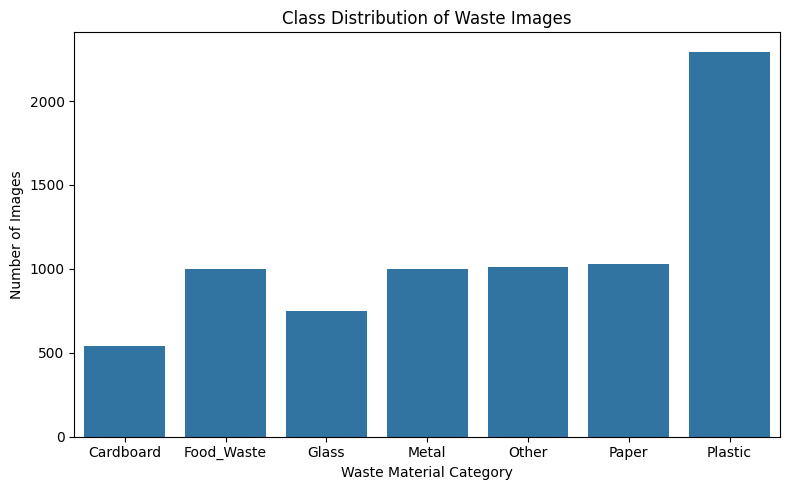

In [ ]:
# Visualise Data Distribution

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Reverse the label_map to get class names from label numbers
inv_label_map = {v: k for k, v in label_map.items()}
label_counts = Counter(y)

# Prepare data for plotting
classes = [inv_label_map[i] for i in label_counts.keys()]
counts = [label_counts[i] for i in label_counts.keys()]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=classes, y=counts)
plt.title("Class Distribution of Waste Images")
plt.xlabel("Waste Material Category")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

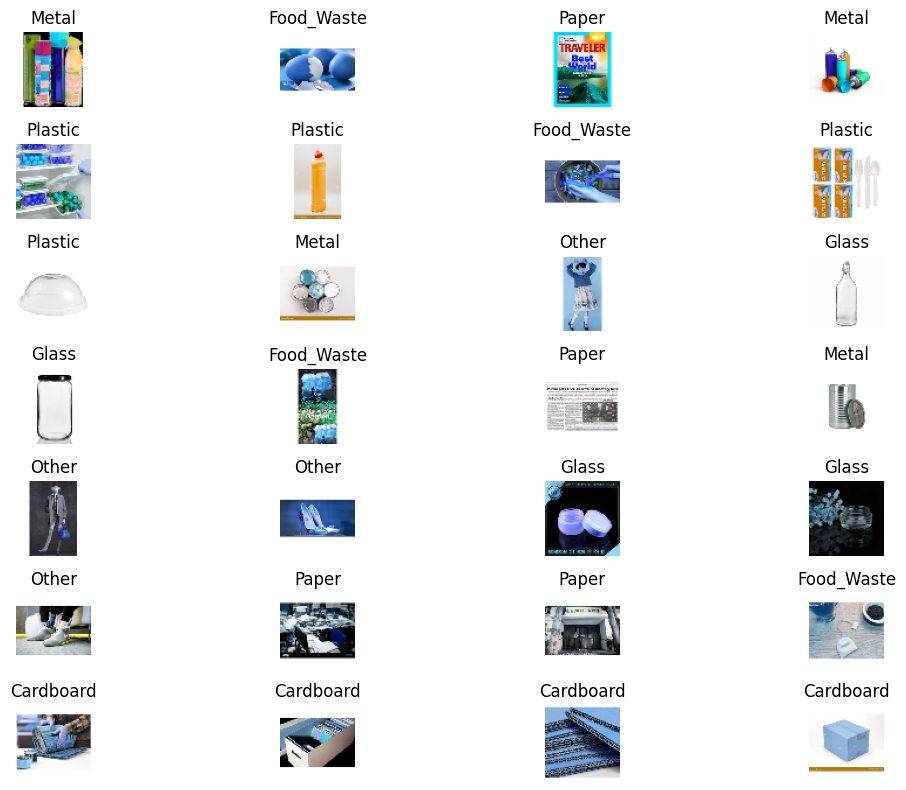

In [ ]:
# Visualise Sample Images (across different labels)

import random

def show_sample_images(X, y, label_map, samples_per_class=3):
    inv_label_map = {v: k for k, v in label_map.items()}
    plt.figure(figsize=(12, 8))

    classes = list(label_map.values())
    class_counts = {cls: 0 for cls in classes}
    shown = 0
    max_to_show = samples_per_class * len(classes)

    for idx in random.sample(range(len(X)), len(X)):
        label = y[idx]
        if class_counts[label] < samples_per_class:
            plt.subplot(len(classes), samples_per_class, shown + 1)
            plt.imshow(X[idx])
            plt.axis('off')
            plt.title(inv_label_map[label])
            class_counts[label] += 1
            shown += 1
        if shown >= max_to_show:
            break

    plt.tight_layout()
    plt.show()

# Call the function
show_sample_images(X, y, label_map, samples_per_class=4)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set

min_height, min_width = float('inf'), float('inf')
max_height, max_width = 0, 0

# Replace 'images' with 'X' to iterate through loaded images
for img in X:
    height, width = img.shape[:2]
    min_height = min(min_height, height)
    min_width = min(min_width, width)
    max_height = max(max_height, height)
    max_width = max(max_width, width)

print(f"Smallest image dimensions: {min_height} x {min_width}")
print(f"Largest image dimensions: {max_height} x {max_width}")

Smallest image dimensions: 64 x 64
Largest image dimensions: 64 x 64


In [ ]:
# Resize the image dimensions

img_size = (150, 150)  # width x height

# This part is already in your load_data function:
# img = cv2.resize(img, img_size)
# So if you’ve already used load_data(), your images (X) are already resized

# Just to confirm shape:
print("Resized image shape:", X[0].shape)



Resized image shape: (64, 64, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably

from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_encoded = to_categorical(y)

# Check the shape of the encoded labels
print("Original y shape:", y.shape)
print("Encoded y shape:", y_encoded.shape)


Original y shape: (7625,)
Encoded y shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y, random_state=42
)

# Confirm shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6100, 64, 64, 3)
y_train shape: (6100, 7)
X_test shape: (1525, 64, 64, 3)
y_test shape: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()

# 1st Conv Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Conv Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Conv Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#  4th Conv Block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # No MaxPooling to retain more spatial info

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))  # 7 classes

# Compile
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,440,967 (5.50 MB)

 Trainable params: 1,440,007 (5.49 MB)

 Non-trainable params: 960 (3.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.2633 - loss: 3.0675
Epoch 1: val_accuracy improved from -inf to 0.30164, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 65s 392ms/step - accuracy: 0.2635 - loss: 3.0663 - val_accuracy: 0.3016 - val_loss: 4.7497
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.3798 - loss: 2.3255
Epoch 2: val_accuracy did not improve from 0.30164
153/153 ━━━━━━━━━━━━━━━━━━━━ 76s 356ms/step - accuracy: 0.3798 - loss: 2.3252 - val_accuracy: 0.1459 - val_loss: 3.9817
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.4300 - loss: 2.0681
Epoch 3: val_accuracy did not improve from 0.30164
153/153 ━━━━━━━━━━━━━━━━━━━━ 54s 351ms/step - accuracy: 0.4300 - loss: 2.0681 - val_accuracy: 0.2090 - val_loss: 4.1365
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4638 - loss: 1.9541
Epoch 4: val_accuracy improved from 0.30164 to 0.41885, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 85s 371ms/step - accuracy: 0.4639 - loss: 1.9542 - val_accuracy: 0.4189 - val_loss: 2.2634
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4995 - loss: 1.8409
Epoch 5: val_accuracy improved from 0.41885 to 0.46475, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 80s 359ms/step - accuracy: 0.4996 - loss: 1.8408 - val_accuracy: 0.4648 - val_loss: 2.0373
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5186 - loss: 1.7882
Epoch 6: val_accuracy improved from 0.46475 to 0.50492, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 58s 379ms/step - accuracy: 0.5187 - loss: 1.7881 - val_accuracy: 0.5049 - val_loss: 2.0490
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5790 - loss: 1.6294
Epoch 7: val_accuracy did not improve from 0.50492
153/153 ━━━━━━━━━━━━━━━━━━━━ 80s 363ms/step - accuracy: 0.5790 - loss: 1.6295 - val_accuracy: 0.4221 - val_loss: 2.3442
Epoch 8/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6161 - loss: 1.5213
Epoch 8: val_accuracy improved from 0.50492 to 0.56148, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 81s 358ms/step - accuracy: 0.6160 - loss: 1.5215 - val_accuracy: 0.5615 - val_loss: 1.7491
Epoch 9/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6267 - loss: 1.4773
Epoch 9: val_accuracy did not improve from 0.56148
153/153 ━━━━━━━━━━━━━━━━━━━━ 81s 355ms/step - accuracy: 0.6266 - loss: 1.4775 - val_accuracy: 0.5533 - val_loss: 1.8459
Epoch 10/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6538 - loss: 1.4113
Epoch 10: val_accuracy did not improve from 0.56148
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 369ms/step - accuracy: 0.6538 - loss: 1.4114 - val_accuracy: 0.4984 - val_loss: 2.2562
Epoch 11/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6722 - loss: 1.3650
Epoch 11: val_accuracy did not improve from 0.56148
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 367ms/step - accuracy: 0.6721 - loss: 1.3651 - val_accuracy: 0.5418 - val_loss: 1.8547
Epoch 12/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7067 - loss: 1.2681
Epoch 12: 

153/153 ━━━━━━━━━━━━━━━━━━━━ 56s 365ms/step - accuracy: 0.7066 - loss: 1.2682 - val_accuracy: 0.5877 - val_loss: 1.6754
Epoch 13/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7281 - loss: 1.2195
Epoch 13: val_accuracy did not improve from 0.58770
153/153 ━━━━━━━━━━━━━━━━━━━━ 84s 377ms/step - accuracy: 0.7280 - loss: 1.2196 - val_accuracy: 0.5205 - val_loss: 2.2186
Epoch 14/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7426 - loss: 1.1641
Epoch 14: val_accuracy did not improve from 0.58770
153/153 ━━━━━━━━━━━━━━━━━━━━ 78s 349ms/step - accuracy: 0.7425 - loss: 1.1643 - val_accuracy: 0.5852 - val_loss: 1.9633
Epoch 15/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7570 - loss: 1.1139
Epoch 15: val_accuracy did not improve from 0.58770
153/153 ━━━━━━━━━━━━━━━━━━━━ 83s 353ms/step - accuracy: 0.7569 - loss: 1.1140 - val_accuracy: 0.5197 - val_loss: 2.5313
Epoch 16/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7876 - loss: 1.0293
Epoch 16

153/153 ━━━━━━━━━━━━━━━━━━━━ 83s 361ms/step - accuracy: 0.7876 - loss: 1.0295 - val_accuracy: 0.6057 - val_loss: 1.7785
Epoch 17/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8044 - loss: 0.9975
Epoch 17: val_accuracy improved from 0.60574 to 0.63279, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 363ms/step - accuracy: 0.8043 - loss: 0.9977 - val_accuracy: 0.6328 - val_loss: 1.6611
Epoch 18/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8285 - loss: 0.9436
Epoch 18: val_accuracy improved from 0.63279 to 0.64344, saving model to best_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 83s 369ms/step - accuracy: 0.8284 - loss: 0.9438 - val_accuracy: 0.6434 - val_loss: 1.7334
Epoch 19/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8262 - loss: 0.9181
Epoch 19: val_accuracy did not improve from 0.64344
153/153 ━━━━━━━━━━━━━━━━━━━━ 54s 353ms/step - accuracy: 0.8261 - loss: 0.9183 - val_accuracy: 0.6254 - val_loss: 1.8016
Epoch 20/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8459 - loss: 0.8737
Epoch 20: val_accuracy did not improve from 0.64344
153/153 ━━━━━━━━━━━━━━━━━━━━ 55s 360ms/step - accuracy: 0.8459 - loss: 0.8739 - val_accuracy: 0.6238 - val_loss: 1.9073
Epoch 21/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8560 - loss: 0.8635
Epoch 21: val_accuracy did not improve from 0.64344
153/153 ━━━━━━━━━━━━━━━━━━━━ 81s 356ms/step - accuracy: 0.8559 - loss: 0.8636 - val_accuracy: 0.5410 - val_loss: 2.5284
Epoch 22/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8685 - loss: 0.8132
Epoch 22

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6216 - loss: 1.7275
✅ Test Accuracy: 0.6164
🧮 Test Loss: 1.7807
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step

📋 Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.68      0.69      0.68       108
  Food_Waste       0.58      0.79      0.67       200
       Glass       0.56      0.67      0.61       150
       Metal       0.69      0.49      0.58       200
       Other       0.50      0.36      0.42       202
       Paper       0.57      0.47      0.52       206
     Plastic       0.67      0.74      0.70       459

    accuracy                           0.62      1525
   macro avg       0.61      0.60      0.60      1525
weighted avg       0.62      0.62      0.61      1525



<ipython-input-53-4e515fe05a85>:31: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


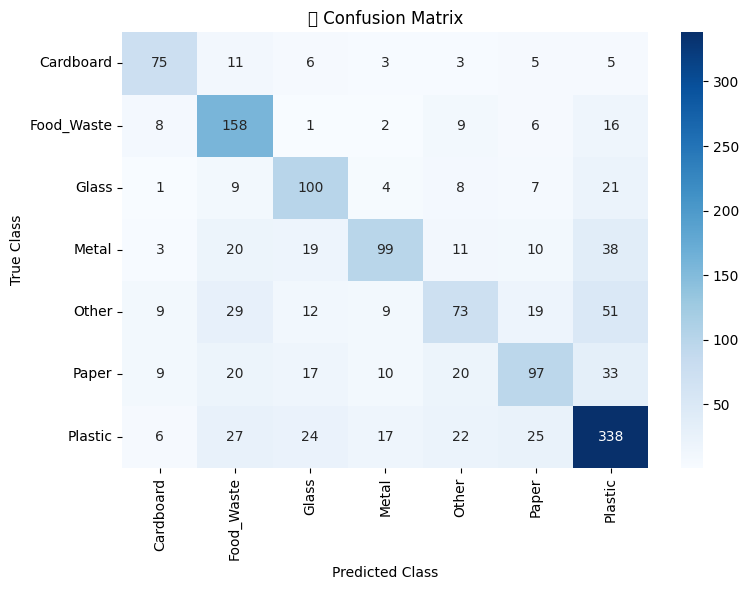

In [ ]:
# Evaluate on the test set; display suitable metrics

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Evaluate loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"🧮 Test Loss: {test_loss:.4f}")

# 2. Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title("🧩 Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

##### **4.1.2**

Train the model on the new augmented dataset.

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

All images were resized to 64×64 pixels to ensure uniformity prior to model training. The dataset consisted of 7,625 labeled images of waste materials, categorized into seven classes: Cardboard, Food_Waste, Glass, Metal, Other, Paper, and Plastic. A data analysis revealed a class imbalance, with Plastic being the most represented and Cardboard the least. This imbalance introduced a potential risk of bias during model training.

To address the classification task, a convolutional neural network (CNN) was designed, incorporating four convolutional blocks along with batch normalization, max pooling, and dropout layers to promote generalization and mitigate overfitting. The model was compiled using the Adam optimizer and trained with categorical cross-entropy loss. Early stopping, learning rate scheduling, and model checkpointing were utilized to optimize the training process.

The model achieved a validation accuracy of 62%, demonstrating strong performance on dominant classes such as Plastic and Food_Waste, while struggling with less frequent or visually ambiguous categories like Other and Paper. Potential future improvements include employing higher-resolution images, applying data augmentation, or using transfer learning techniques to enhance generalization and overall accuracy.